In [27]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import math
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os.path
import os

# Setup

In [28]:
with_obstacles = False

data_from = ''
path = "G:/Bachelor/Data" + data_from

csv = ".csv"

def getConstants(path):
    name = 'constants.csv'
    constants = pd.read_csv(f"{path}/{name}")
    out = {}
    out['stationary_t'] = int(constants['stationary_t'])
    out['avg'] = int(constants['avg'])
    out['delta_t'] = float(constants['delta_t'])
    out['a'] = int(constants['a'])
    out['w'] = int(constants['w'])
    out['h'] = int(constants['h'])
    out['num_particles'] = int(constants['num_particles'])
    out['m'] = int(constants['m'])
    out['k_BT'] = float(constants['k_BT'])
    out['g'] = float(constants['g'])
    if 'last_timestep' in constants.columns:
        out['last_timestep'] = constants['last_timestep']
    return out

constants = getConstants(path)
x_dim = constants['w']
y_dim = constants['h']
stationary = constants['stationary_t']

## Load

In [29]:
def load_obstacles(parent):
        obstacles_path = f'{parent}/constants_obstacles.csv'
        obstacles_csv = pd.read_csv(obstacles_path)
        return obstacles_csv
    

def get_last_timestep(parent):
    if 'last_timestep' in constants:
        return constants['last_timestep']
    else:
    
        filenames_monomers = glob.glob(f'{parent}/monomers_av*.csv')
        last = filenames_monomers[-1]
        num_last = int(last.split("timestep")[1].replace(".csv", "")) - 1

        os.remove(last)

        particles_filename = f'{parent}/particles_av{constants["avg"]}_timestep0{num_last+1}.csv'
        if os.path.exists(particles_filename):
            os.remove(particles_filename)
            print("Deleted last (maybe incomplete) particles file)")

        cells_filename = f'{parent}/cells_av{constants["avg"]}_timestep0{num_last+1}.csv'
        if os.path.exists(cells_filename):
            os.remove(cells_filename)
            print("Deleted last (maybe incomplete) cells file)")
        
        constants['last_timestep'] = num_last
        df = pd.DataFrame(constants, index = [0])
        df.to_csv(f'{parent}/constants.csv', index = False)
        
        print('Saved new constants file')

        return num_last

def load_monomers(parent, constants):
    monomers_t = []

    # Loading particles
    print('Loading Monomers ..')
    filenames_monomers = glob.glob(f'{parent}/monomers_av*.csv')
    for it, file in enumerate(filenames_monomers):
        monomers_t.append(pd.read_csv(file))
        if (it % 500 == 0):
            print('--loaded {}'.format(it))
    print('Monomers loaded and saved!\n')
    # Monomers loaded
    return monomers_t


def load_particles(parent):
    particles_stationary = pd.read_csv(f'{parent}/particles_av{constants["avg"]}_timestep0{stationary-1}.csv')
    print('Particles loaded.\n')
    
    return particles_stationary

def load_cells(parent):
    print('Loading cells')
    cells_timesteps = []

    filenames_cells = glob.glob(f'{parent}/cells_av*.csv'.format(path))
    for it, file in enumerate(filenames_cells):
        df = pd.read_csv(file)
        cells_timesteps.append(df)
        if (it % 500 == 0):
            print('--loaded {}'.format(it))
        it += 1
    print('Cells loaded and saved!\n')
    # Cells loaded
    return cells_timesteps
    
parent_dir = path
num_timesteps = get_last_timestep(parent_dir)
monomers_t = load_monomers(parent_dir, constants)
#particles = load_particles(parent_dir)
cells_timesteps = load_cells(parent_dir)

obstacles = []
if (with_obstacles):
    obstacles = loadObstacles(parent_dir)

Saved new constants file
Loading Monomers ..
--loaded 0
--loaded 500
Monomers loaded and saved!

Loading cells
--loaded 0
Cells loaded and saved!



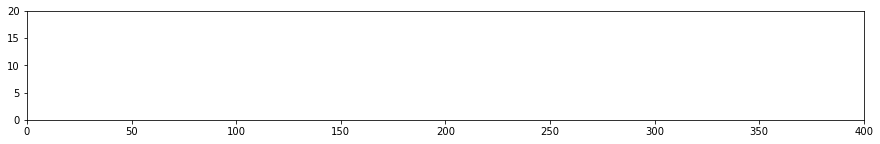

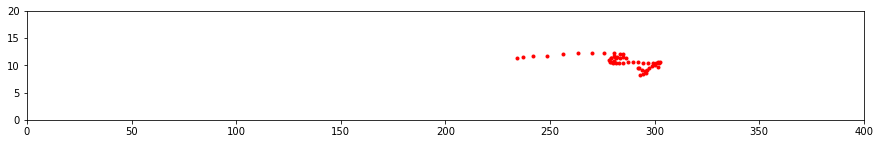

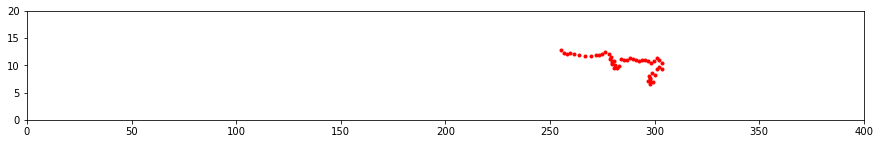

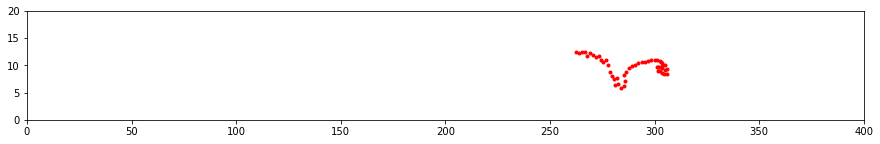

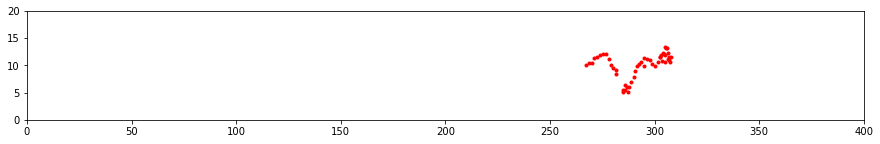

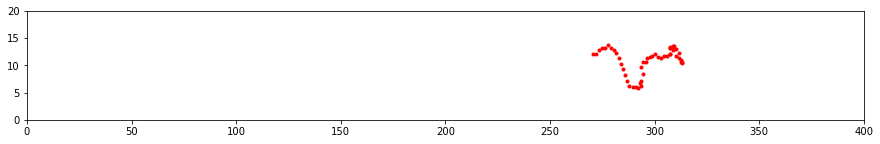

In [30]:
point_size = 3
for it, df in enumerate(monomers_t):
    if (it % 100 == 0):
        plt.figure(figsize = (15,2))
        scatter = plt.plot(df['x'], df['y'], 'o', markersize = point_size, color = 'red')
        plt.xlim((0, 400))
        plt.ylim((0, 20))
        plt.savefig(f"Test/monomer_plot_{it}.png")
        plt.show()

# Plot

In [20]:
x_region = (0, x_dim)
y_region = (0, y_dim)

def process_plotdata(x_region, y_region):
    x0_obstacles = x_region[0]
    x1_obstacles = x_region[1]
    y0_obstacles = y_region[0]
    y1_obstacles = y_region[1]
    x = np.arange(x0_obstacles, x1_obstacles)
    y = np.arange(y0_obstacles, y1_obstacles)
    X, Y = np.meshgrid(x, y)
    cells = cells_timesteps[-1].set_index(['i', 'j'])
    vx = np.array([[cells['meanX'].loc[row, col] for col in x] for row in y])
    vy = np.array([[cells['meanY'].loc[row, col] for col in x] for row in y])
    pivot = cells.reset_index().pivot(index = 'i', columns = 'j', values = 'num')
    return X, Y, vx, vy, pivot

X, Y, vx, vy, pivot = process_plotdata(x_region, y_region)

# Plot settings
streamplot_density = 2
point_size = 0.3
color = np.sqrt(vx**2 + vy**2)
plot_x_region = (x_region[0] - 1, x_region[1])
plot_y_region = (y_region[0] - 1, y_region[1])

Plotting data ..
Data plotted and saved!


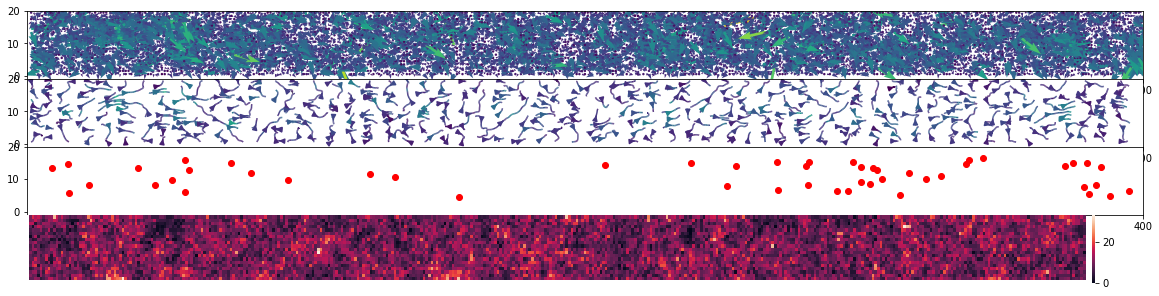

In [22]:
print('Plotting data ..')
fig = plt.figure(figsize=(20,5))
ax = [fig.add_subplot(4,1,i+1) for i in range(4)]

#for a in ax:
#    a.set_xticklabels([])
#    a.set_yticklabels([])
    #a.set_aspect('equal')
    
fig.subplots_adjust(wspace=0, hspace=0)

if with_obstacles:
    for index, o in obstacles.iterrows():
        circle1 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'orange')
        circle2 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'orange')
        #circle3 = plt.Circle((o['x'], o['y']), obstacle_radius, color = 'black')
        #circles.append(circle)
        ax[1].add_artist(circle1)
        ax[2].add_artist(circle2)
        #ax[3].add_artist(circle3)
        #ax[0].xaxis.set_ticks([])

#ax[0].xaxis.set_ticks([])
#ax[0].yaxis.set_ticks([])
ax[0].quiver(X + 0.5, Y + 0.5, vx, vy, color)
ax[0].set(xlim=plot_x_region, ylim=plot_y_region)

#ax[1].xaxis.set_ticks([])
#ax[1].yaxis.set_ticks([])
ax[1].streamplot(X + 0.5, Y + 0.5, vx, vy, color=color, density=streamplot_density) # grid
ax[1].set(xlim=plot_x_region, ylim=plot_y_region)

#ax[2].xaxis.set_ticks([])
#ax[2].yaxis.set_ticks([])
#ax[2].plot(particles['x'], particles['y'], "o", markersize = point_size)
monomers = monomers_t[-1]
ax[2].plot(monomers['x'], monomers['y'], 'o', markersize = point_size * 20, color = 'red')
ax[2].set(xlim=plot_x_region, ylim=plot_y_region)

#ax[3].xaxis.set_ticks([])
#ax[3].yaxis.set_ticks([])
#img = ax[3].imshow(pivot, cmap='hot')
#fig.colorbar(img, ax=ax[3], fraction=0.046, pad=0.005)
sns.heatmap(pivot, ax=ax[3], xticklabels = False, yticklabels = False, cbar_kws={"fraction": 0.046, "pad": 0.005})
ax[3].set(xlim=plot_x_region, ylim=plot_y_region)
#ax[3].xticks('')
#ax[3].yticks('')
ax[3].set_ylabel('')
ax[3].set_xlabel('')
#ax[1,1].imshow(pivot, cmap='hot')

plt.savefig("Assets/stationary_region.png")
#plt.close()
print('Data plotted and saved!')

# Reality Check

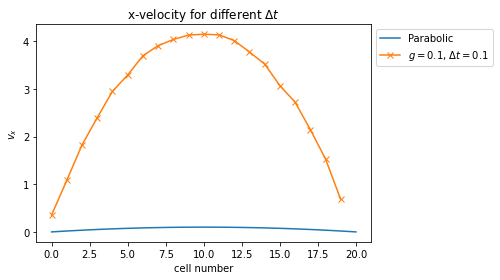

In [11]:
def viscosity(v_max, m = 1, av_N_c = 10, g = 0.01, D = 50):
    return (m * av_N_c * g * D**2) / (8 * v_max)

def parabolic_flow(y, D, v_max = 0.1):
    return (4 * v_max * (D - y) * y)/(D**2)
    

y = np.linspace(0, y_dim, 100)
plt.plot(y, parabolic_flow(y, y_dim), label = 'Parabolic')

data_dirs = [''] #400x50_0.01g_0.05t/', '400x50_0.01g_0.1t/', '400x50_0.01g_0.15t/', '400x50_0.01g_0.2t/'
for config in data_dirs:
    cells = cells_timesteps[-1].set_index(['i', 'j'])
    velocities_i = cells['meanX'].groupby('i').mean()
    plt.plot(velocities_i, '-x', label = '$g = {}$, $\Delta t = {}$'.format(constants['g'], constants['delta_t']))#.mean(axis = 1)
plt.legend(bbox_to_anchor=(1,1))
plt.title('x-velocity for different $\Delta t$')
plt.ylabel('$v_x$')
plt.xlabel('cell number')
#plt.savefig('Assets/poseuille.png')
plt.show()

NameError: name 'particles' is not defined

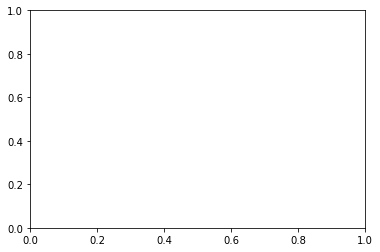

In [12]:
def theoretical_dist(Delta_v, N_c, av_N_c = 10, m = 1, k_B = 1, T = 1):
    A = (m/(2 * math.pi * k_B * T * (1 - 1/N_c)))**(3/2)
    B = np.exp(-(m/(2 * k_B * T * (1 - 1/N_c))) * Delta_v**2)
    return A * B

def poisson_avg(Delta_v, max_sum = 1000, av_N_c = 10, m = 1, k_B = 1, T = 1):
    e = math.exp(-av_N_c)
    total = 0
    for N_c in range(2, max_sum):
        P = (av_N_c**N_c)/(math.factorial(N_c))
        N = theoretical_dist(Delta_v, N_c, m, k_B, T)
        total += P * (N)
    D = 1 - (av_N_c + 1) * e
    return e * total/D

data_dirs = [''] #400x50_0.01g_0.05t/, '400x50_0.01g_0.1t/', '400x50_0.01g_0.15t/', '400x50_0.01g_0.2t/'
fig, ax = plt.subplots(nrows = 1, ncols = 1)
for config in data_dirs:
    particles["i"] = (particles["y"] / constants["a"]).apply(lambda i: floor(i))
    particles["j"] = (particles["x"] / constants["a"]).apply(lambda i: floor(i))
    complete = pd.merge(particles, cells, how = 'inner', on = ["i", "j"])
    complete["Delta_vx"] = complete["vx"] - complete["meanX"]
    complete["Delta_vy"] = complete["vy"] - complete["meanY"]
    complete["Delta_v"] = np.sqrt(complete["Delta_vx"]**2 + complete["Delta_vy"]**2)
    mid_i = (particles["i"] >= 1/4*y_dim) & (particles["i"] <= 35)
    subselection = complete.loc[mid_i]
    sns.kdeplot(subselection["Delta_v"]/ math.sqrt(constants["k_BT"] / constants["m"]),
                ax = ax, label = '$g = {}$, $\Delta t = {}$'.format(constants["g"], constants["delta_t"]))
    #ax.plot(subselection["Delta_v"], poisson_avg(subselection["Delta_v"]/ math.sqrt(constants["k_BT"] / constants["m"])), 'o')# ,ax = ax
ax.legend()
ax.set_title('Distribution of velocity in a cell')
ax.set_ylabel('Frequency')
ax.set_xlabel('$|\Delta v|$')
plt.savefig("Assets/Delta_v_dist.png")
plt.show()

# Monomer animation

--Created 0 frame.

--Created 0 frame.

--Created 0 frame.



KeyboardInterrupt: 

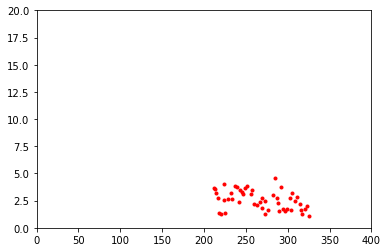

In [13]:
from matplotlib import animation

fig = plt.figure()
ax = plt.axes(xlim=(0, 400), ylim=(0, 20))

point_size = 3
df = monomers_t[0]
scatter, = ax.plot(df['x'], df['y'], 'o', markersize = point_size, color = 'red')

# animation function.  This is called sequentially
def animate(it):
    df = monomers_t[it]
    scatter.set_xdata(df['x'])
    scatter.set_ydata(df['y'])
    if (it % 100 == 0):
        print('--Created {} frame.\n'.format(it))
    return scatter,

anim = animation.FuncAnimation(fig, animate, #init_func=init,
                               frames=len(monomers_t), blit=True)

anim.save('./Assets/monomer_animation.mp4', fps=5, extra_args=['-vcodec', 'libx264'])
print('Animated and saved!')

plt.show()
#plt.close()

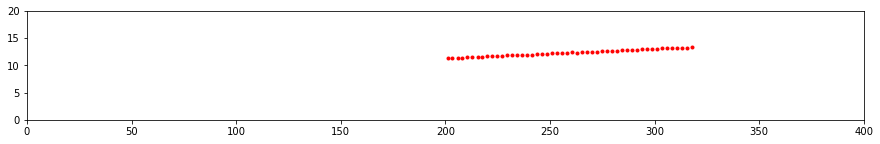

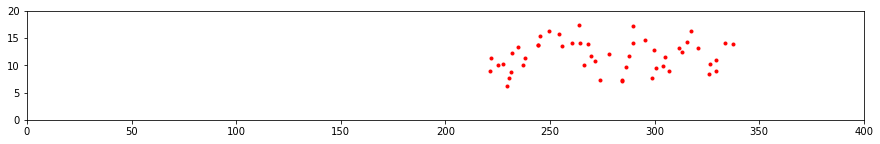

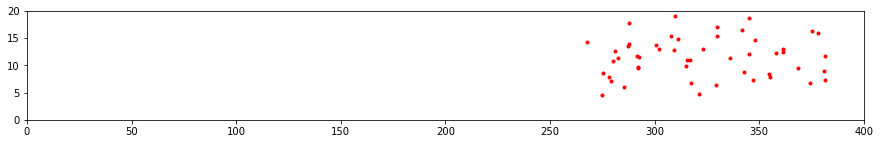

In [13]:
point_size = 3
for it, df in enumerate(monomers_t):
    if (it % 200 == 0):
        plt.figure(figsize = (15,2))
        scatter = plt.plot(df['x'], df['y'], 'o', markersize = point_size, color = 'red')
        plt.xlim((0, 400))
        plt.ylim((0, 20))
        plt.savefig(f"Test/monomer_plot_{it}.png")
        plt.show()


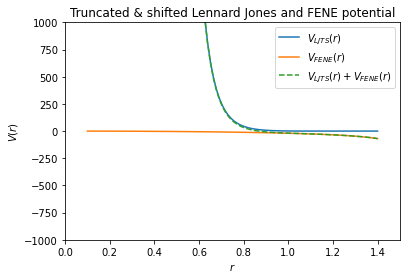

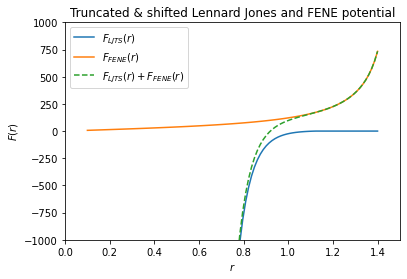

In [26]:
def V_LJTS(d, tuning, diameter, r_end):
    f = [V_LJ(r, tuning, diameter) - V_LJ(r_end, tuning, diameter) if r <= r_end else 0 for r in d]
    return f

def V_LJ(d, tuning, diameter):
    return 4 * tuning * ((diameter**12) / (d**12) - (diameter**6) / (d**6));

def V_FENE(d, tuning, diameter, k, R0):
    f = k/2 * tuning / (diameter**2) * R0**2 * np.log(1 - d**2/(1.5**2))
    return f

# --------- PARAMETERS ---------- #
tuning = 1
diameter = 1
r_end = 2**(1/6) * diameter
R0 = 1.5 * diameter
k = 30
d = np.linspace(0.1, 1.4, 100)


# -------- POTENTIAL PLOTTING ------- #
plt.plot(d, V_LJTS(d, tuning, diameter, r_end), label = '$V_{LJTS}(r)$')
plt.plot(d, V_FENE(d, tuning, diameter, k, R0), label = '$V_{FENE}(r)$')
plt.plot(d, V_LJTS(d, tuning, diameter, r_end) + V_FENE(d, tuning, diameter, k, R0), '--', label = '$V_{LJTS}(r) + V_{FENE}(r)$')
plt.xlim(0, 1.5)
plt.xlabel('$r$')
plt.ylim(-1000, 1000)
plt.ylabel('$V(r)$')
plt.title('Truncated & shifted Lennard Jones and FENE potential')
plt.legend()
plt.show()

def LJ_trunc(d, tuning, diameter, r_end):
    f = [LJ(r, tuning, diameter) if r <= r_end else 0 for r in d] #- LJ(r_end, tuning, diameter)
    return f
    
def LJ(d, tuning, diameter):
    return 4 * tuning * (-12 * (diameter**12) / (d**13) - (-6 * diameter**6) / (d**7));

def FENE(d, tuning, diameter, k, R0):
    f = k * tuning/(diameter**2) * R0**2 * d/(1 - (d/R0)**2)
    return f

# ---------- FORCE PLOTTING --------- #
plt.plot(d, LJ_trunc(d, tuning, diameter, r_end), label = '$F_{LJTS}(r)$')
plt.plot(d, FENE(d, tuning, diameter, k, R0), label = '$F_{FENE}(r)$')
plt.plot(d, LJ_trunc(d, tuning, diameter, r_end) + FENE(d, tuning, diameter, k, R0), '--', label = '$F_{LJTS}(r) + F_{FENE}(r)$')
plt.xlim(0, 1.5)
plt.xlabel('$r$')
plt.ylim(-1000, 1000)
plt.ylabel('$F(r)$')
plt.title('Truncated & shifted Lennard Jones and FENE potential')
plt.legend()
plt.show()